<a href="https://colab.research.google.com/github/ksushrut/CoinClassifier/blob/main/Models_SushrutPhase2_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Sushrut Kuchik

Student ID: 47944250

Unit: COMP8430 - Advanced Computer and Vision

Assignment: Phase 2, Major Project

In [33]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import zipfile

In [34]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
!cp -r "/content/drive/My Drive/CoinImages/compressed" /content/

In [36]:
import zipfile
import os

# Path to your uploaded zip file
zip_path = "/content/compressed/PreprocessedCoinImages.zip"

# Destination directory
extract_dir = "/content/PreprocessedCoinImages"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Files extracted to: {extract_dir}")

Files extracted to: /content/PreprocessedCoinImages


In [37]:
csv_loc='https://raw.githubusercontent.com/ksushrut/CoinClassifier/refs/heads/main/processed_data.csv'

In [38]:
df=pd.read_csv(csv_loc)
df

,URL,image name,country,width,height,label
0,/content/drive/My Drive/CoinImages/Preprocesse...,14t.jpg,Australia,224,224,AUD 50 Cents
1,/content/drive/My Drive/CoinImages/Preprocesse...,10t.jpg,Australia,224,224,AUD 50 Cents
2,/content/drive/My Drive/CoinImages/Preprocesse...,13t.jpg,Australia,224,224,AUD 50 Cents
3,/content/drive/My Drive/CoinImages/Preprocesse...,3h.jpg,Australia,224,224,AUD 50 Cents
4,/content/drive/My Drive/CoinImages/Preprocesse...,2h.jpg,Australia,224,224,AUD 50 Cents
...,...,...,...,...,...,...
2418,/content/drive/My Drive/CoinImages/Preprocesse...,4h.jpeg,India,224,224,INR 10Rs
2419,/content/drive/My Drive/CoinImages/Preprocesse...,24h.jpeg,India,224,224,INR 10Rs
2420,/content/drive/My Drive/CoinImages/Preprocesse...,11t.jpeg,India,224,224,INR 10Rs
2421,/content/drive/My Drive/CoinImages/Preprocesse...,3h.jpeg,India,224,224,INR 10Rs


In [39]:
label_encoder = LabelEncoder()
df['encoded_class'] = label_encoder.fit_transform(df['label'])

In [40]:
df['URL'] = df['URL'].str.replace("/content/drive/My Drive/CoinImages/Preprocessed_Images",
                                  "/content/PreprocessedCoinImages")

In [41]:
df

,URL,image name,country,width,height,label,encoded_class
0,/content/drive/My Drive/CoinImages/Preprocesse...,14t.jpg,Australia,224,224,AUD 50 Cents,23
1,/content/drive/My Drive/CoinImages/Preprocesse...,10t.jpg,Australia,224,224,AUD 50 Cents,23
2,/content/drive/My Drive/CoinImages/Preprocesse...,13t.jpg,Australia,224,224,AUD 50 Cents,23
3,/content/drive/My Drive/CoinImages/Preprocesse...,3h.jpg,Australia,224,224,AUD 50 Cents,23
4,/content/drive/My Drive/CoinImages/Preprocesse...,2h.jpg,Australia,224,224,AUD 50 Cents,23
...,...,...,...,...,...,...,...
2418,/content/drive/My Drive/CoinImages/Preprocesse...,4h.jpeg,India,224,224,INR 10Rs,32
2419,/content/drive/My Drive/CoinImages/Preprocesse...,24h.jpeg,India,224,224,INR 10Rs,32
2420,/content/drive/My Drive/CoinImages/Preprocesse...,11t.jpeg,India,224,224,INR 10Rs,32
2421,/content/drive/My Drive/CoinImages/Preprocesse...,3h.jpeg,India,224,224,INR 10Rs,32


In [42]:
df_sushrut = df[(df['country'] == 'India') | (df['country'] == 'United States')].reset_index(drop=True)

In [43]:
class CoinImageDataset(Dataset):
    def __init__(self, dataframe,transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform=transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_folder = row['URL']
        img_name = str(row['image name']).strip()
        img_path = img_folder +'/'+ img_name
        label = row['encoded_class']

        image = Image.open(img_path).convert("RGB")
        image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0
        return image, label

In [44]:
train_df, val_test_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['encoded_class'])
val_df, test_df = train_test_split(val_test_df, test_size=0.75,
random_state=42, stratify=val_test_df['encoded_class'])

train_dataset = CoinImageDataset(train_df)
val_dataset = CoinImageDataset(val_df)
test_dataset = CoinImageDataset(test_df)


train_loader = DataLoader(train_dataset, batch_size=32,
shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
sushruttrain_df, sushrutval_test_df = train_test_split(df_sushrut, test_size=0.4, random_state=42, stratify=df_sushrut['encoded_class'])
sushrutval_df, sushruttest_df = train_test_split(sushrutval_test_df, test_size=0.75,
random_state=42, stratify=sushrutval_test_df['encoded_class'])

train_dataset = CoinImageDataset(train_df)
val_dataset = CoinImageDataset(val_df)
test_dataset = CoinImageDataset(test_df)

sushrut_train_loader = DataLoader(train_dataset, batch_size=32,
shuffle=True)
sushrut_val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
sushrut_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [46]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = 100 * correct / total
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")
    model.train()
    return val_acc

In [47]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device,scheduler, num_epochs=10):
    lrs=[]
    train_acc=[]
    val_acc=[]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        print(f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = 100 * correct / total
        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")
        val_accuracy=validate_model(model, val_loader, criterion, device)
        scheduler.step()
        train_acc.append(epoch_acc)
        val_acc.append(val_accuracy)
        lrs.append(optimizer.param_groups[0]['lr'])
    return lrs,train_acc,val_acc

In [48]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss /= total
    test_acc = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# AlexNet FineTuning

In [49]:
import torch
import torch.nn as nn
from torchvision import models

class AlexNetFineTuner(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetFineTuner, self).__init__()
        self.alexnet = models.alexnet(pretrained=True)

        for idx in [1, 3]:
            for param in self.alexnet.classifier[idx].parameters():
                param.requires_grad = False
        self.alexnet.classifier[6] = nn.Linear(self.alexnet.classifier[6].in_features, num_classes)

    def forward(self, x):
        return self.alexnet(x)

In [50]:
num_classes = df['encoded_class'].nunique()
print("Number of classes",num_classes)
alex_finetunemodel = AlexNetFineTuner(num_classes=num_classes)
print(alex_finetunemodel)

Number of classes 48


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNetFineTuner(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False

In [ ]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alex_finetunemodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_finetunemodel.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

lrs,train_acc,val_acc=train_model(alex_finetunemodel, train_loader, sushrut_val_loader, criterion, optimizer,device, scheduler)
# Save the model after training
torch.save(alex_finetunemodel.state_dict(), 'alex_finetunemodel.pth')
print("Model saved as 'alex_finetunemodel.pth'")

Epoch 1/10
Train Loss: 3.7161 | Train Acc: 7.71%
Val Loss: 3.0198 | Val Acc: 26.86%

Epoch 2/10
Train Loss: 2.4189 | Train Acc: 36.06%
Val Loss: 1.8791 | Val Acc: 48.76%

Epoch 3/10
Train Loss: 1.4427 | Train Acc: 58.98%
Val Loss: 1.3971 | Val Acc: 63.64%

Epoch 4/10
Train Loss: 0.9078 | Train Acc: 73.30%
Val Loss: 1.3024 | Val Acc: 66.12%

Epoch 5/10
Train Loss: 0.5006 | Train Acc: 85.20%
Val Loss: 1.2763 | Val Acc: 68.60%

Epoch 6/10
Train Loss: 0.2728 | Train Acc: 91.74%
Val Loss: 1.0615 | Val Acc: 71.90%

Epoch 7/10
Train Loss: 0.1893 | Train Acc: 94.29%
Val Loss: 1.1548 | Val Acc: 69.83%

Epoch 8/10
Train Loss: 0.1288 | Train Acc: 96.08%
Val Loss: 1.1176 | Val Acc: 70.25%

Epoch 9/10
Train Loss: 0.1034 | Train Acc: 97.38%
Val Loss: 1.1858 | Val Acc: 71.90%

Epoch 10/10
Train Loss: 0.0846 | Train Acc: 97.73%
Val Loss: 1.2124 | Val Acc: 71.49%

Model saved as 'alex_finetunemodel.pth'


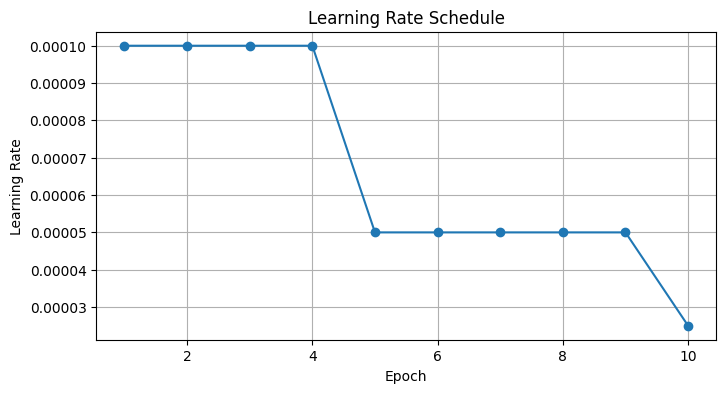

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), lrs, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

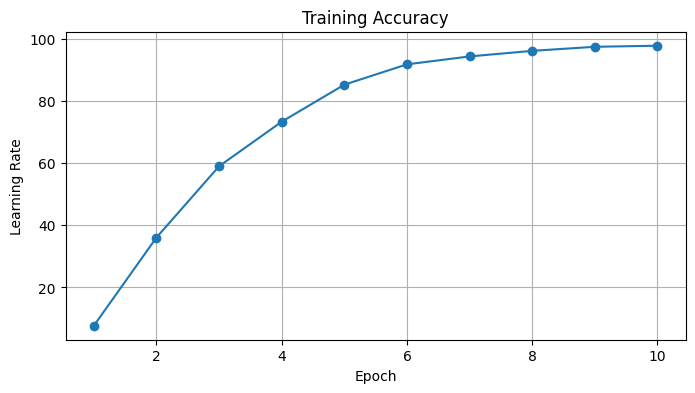

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), train_acc, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

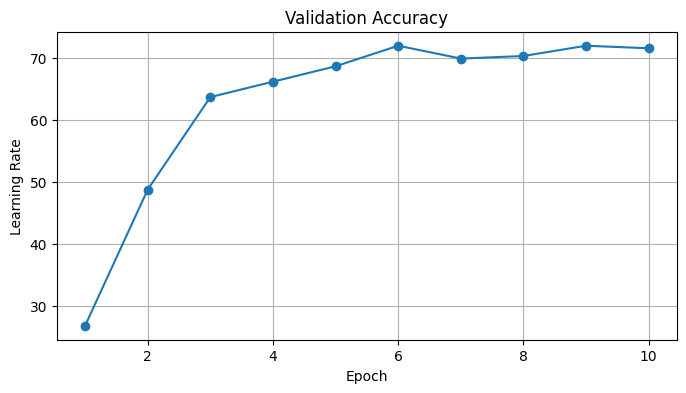

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), val_acc, marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alex_finetunemodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_finetunemodel.parameters(), lr=1e-4)
alex_finetunemodel.eval()  # Set the model to evaluation mode
test_model(alex_finetunemodel, sushrut_test_loader, criterion, device)

Test Loss: 1.1221 | Test Accuracy: 73.49%


#### Conclusion

The AlexNet performs great for training data which contains all the images and then performs satisfactorily with an accuracy of around 73.5% for the images collected by me(India and United States coin images).

# VCG FineTuning

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class PretrainedVGG16(nn.Module):
    def __init__(self, num_classes,freeze_features=True):
        super(PretrainedVGG16, self).__init__()
        self.vgg = models.vgg16(pretrained=True)

        for idx in [1,2,3,4,5]:
            for param in self.vgg.classifier[idx].parameters():
                param.requires_grad = False

        self.vgg.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

In [ ]:
num_classes = df['encoded_class'].nunique()
print("Number of classes",num_classes)
vgg_finetunedmodel = PretrainedVGG16(num_classes=num_classes)
print(vgg_finetunedmodel)

Number of classes 48


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PretrainedVGG16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [ ]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_finetunedmodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_finetunedmodel.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

lrs,train_acc,val_acc=train_model(vgg_finetunedmodel, train_loader, sushrut_val_loader, criterion, optimizer,device, scheduler)
# Save the model after training
torch.save(vgg_finetunedmodel.state_dict(), 'vgg_finetunemodel.pth')
print("Model saved as 'vgg_finetunemodel.pth'")

Epoch 1/10
Train Loss: 3.4742 | Train Acc: 13.15%
Val Loss: 2.1895 | Val Acc: 52.48%

Epoch 2/10
Train Loss: 1.6300 | Train Acc: 56.92%
Val Loss: 1.0074 | Val Acc: 71.49%

Epoch 3/10
Train Loss: 0.7121 | Train Acc: 78.94%
Val Loss: 0.8513 | Val Acc: 74.38%

Epoch 4/10
Train Loss: 0.4191 | Train Acc: 86.72%
Val Loss: 1.0653 | Val Acc: 76.86%

Epoch 5/10
Train Loss: 0.2658 | Train Acc: 92.29%
Val Loss: 0.8339 | Val Acc: 77.69%

Epoch 6/10
Train Loss: 0.1123 | Train Acc: 96.49%
Val Loss: 0.7041 | Val Acc: 83.06%

Epoch 7/10
Train Loss: 0.0635 | Train Acc: 97.73%
Val Loss: 0.7433 | Val Acc: 82.23%

Epoch 8/10
Train Loss: 0.0658 | Train Acc: 98.00%
Val Loss: 0.7690 | Val Acc: 82.64%

Epoch 9/10
Train Loss: 0.0496 | Train Acc: 98.49%
Val Loss: 0.8096 | Val Acc: 80.99%

Epoch 10/10
Train Loss: 0.0401 | Train Acc: 98.69%
Val Loss: 0.8443 | Val Acc: 83.88%

Model saved as 'vgg_finetunemodel.pth'


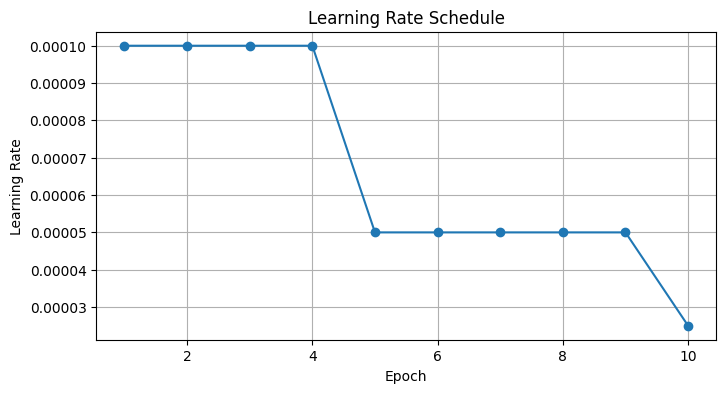

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), lrs, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

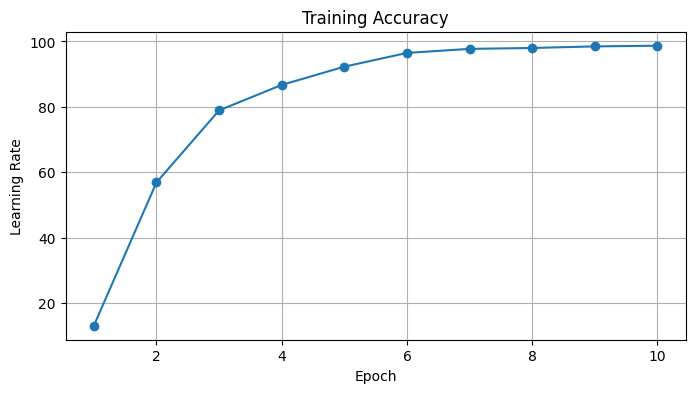

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), train_acc, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

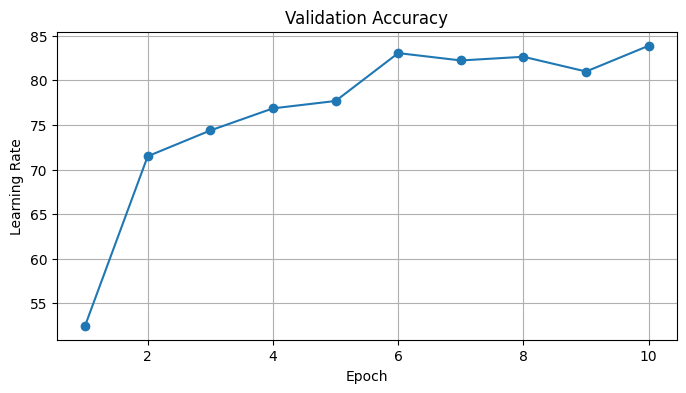

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), val_acc, marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_finetunedmodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_finetunedmodel.parameters(), lr=1e-4)
vgg_finetunedmodel.eval()  # Set the model to evaluation mode
test_model(vgg_finetunedmodel, sushrut_test_loader, criterion, device)

Test Loss: 0.7676 | Test Accuracy: 84.07%


#### Conclusion


The VGG performs great for training data which contains all the images and then performs satisfactorily with an accuracy of around 84.07% for the images collected by me(India and United States coin images).

# Augmentation

## Alexnet with data augmentation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                         # Resize to standard input size
    transforms.RandomHorizontalFlip(p=0.2),                # Mild flipping
    transforms.RandomRotation(degrees=5),                  # Small rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4785, 0.5099, 0.5338],
                         std=[0.2261, 0.2196, 0.2504])
])

In [ ]:
train_dataset = CoinImageDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
sushruttrain_df, sushrutval_test_df = train_test_split(df_sushrut, test_size=0.4, random_state=42, stratify=df_sushrut['encoded_class'])
sushrutval_df, sushruttest_df = train_test_split(sushrutval_test_df, test_size=0.75,
random_state=42, stratify=sushrutval_test_df['encoded_class'])

train_dataset = CoinImageDataset(train_df,transform=train_transforms)
val_dataset = CoinImageDataset(val_df,transform=train_transforms)
test_dataset = CoinImageDataset(test_df,transform=train_transforms)

sushrut_train_loader = DataLoader(train_dataset, batch_size=32,
shuffle=True)
sushrut_val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
sushrut_test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
alex_finetunemodel = AlexNetFineTuner(num_classes=num_classes)
print(alex_finetunemodel)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNetFineTuner(
  (alexnet): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False

In [ ]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alex_finetunemodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_finetunemodel.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

lrs,train_acc,val_acc=train_model(alex_finetunemodel, train_loader, sushrut_val_loader, criterion, optimizer,device, scheduler)
# Save the model after training
torch.save(alex_finetunemodel.state_dict(), 'alex_finetunemodel.pth')
print("Model saved as 'alex_finetunemodel.pth'")

Epoch 1/10
Train Loss: 3.6204 | Train Acc: 11.01%
Val Loss: 2.7329 | Val Acc: 30.99%

Epoch 2/10
Train Loss: 2.1758 | Train Acc: 41.16%
Val Loss: 1.6563 | Val Acc: 56.20%

Epoch 3/10
Train Loss: 1.2345 | Train Acc: 64.07%
Val Loss: 1.2811 | Val Acc: 64.88%

Epoch 4/10
Train Loss: 0.7206 | Train Acc: 78.18%
Val Loss: 1.1250 | Val Acc: 66.94%

Epoch 5/10
Train Loss: 0.4822 | Train Acc: 84.72%
Val Loss: 1.1455 | Val Acc: 67.77%

Epoch 6/10
Train Loss: 0.2181 | Train Acc: 93.94%
Val Loss: 0.9813 | Val Acc: 71.49%

Epoch 7/10
Train Loss: 0.1301 | Train Acc: 96.49%
Val Loss: 0.9877 | Val Acc: 75.21%

Epoch 8/10
Train Loss: 0.1188 | Train Acc: 96.97%
Val Loss: 1.0697 | Val Acc: 71.90%

Epoch 9/10
Train Loss: 0.1221 | Train Acc: 96.35%
Val Loss: 1.1503 | Val Acc: 71.49%

Epoch 10/10
Train Loss: 0.0951 | Train Acc: 97.18%
Val Loss: 0.9880 | Val Acc: 74.38%

Model saved as 'alex_finetunemodel.pth'


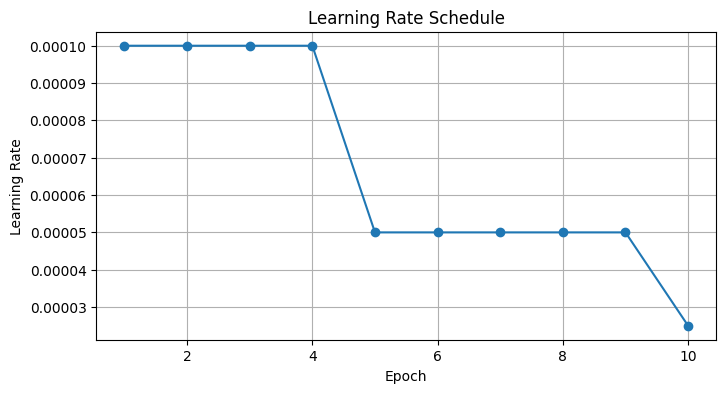

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), lrs, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

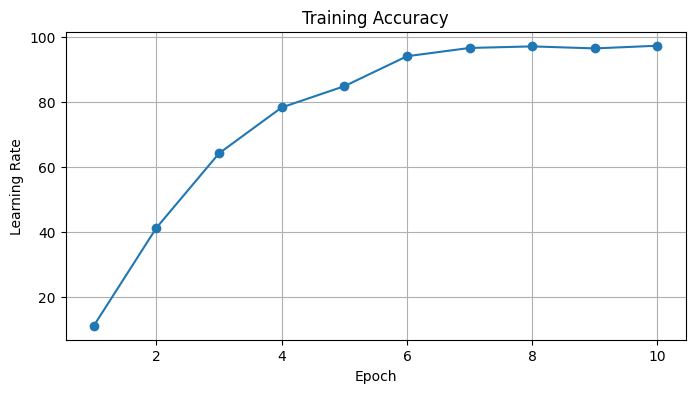

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), train_acc, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

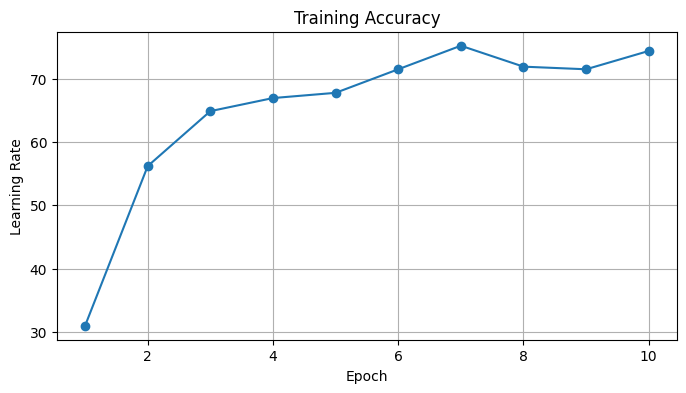

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), val_acc, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alex_finetunemodel.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alex_finetunemodel.parameters(), lr=1e-4)
alex_finetunemodel.eval()  # Set the model to evaluation mode
test_model(alex_finetunemodel, sushrut_test_loader, criterion, device)

Test Loss: 1.0675 | Test Accuracy: 73.49%


#### Conclusion

The accuracy remains the same after data augmentation

## VGG with data augmentation

In [ ]:
vgg_model = PretrainedVGG16(num_classes=num_classes)
print(vgg_model)

PretrainedVGG16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [ ]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

lrs,train_acc,val_acc=train_model(vgg_model, train_loader, sushrut_val_loader, criterion, optimizer,device, scheduler)
# Save the model after training
torch.save(vgg_model.state_dict(), 'vgg_finetunemodel.pth')
print("Model saved as 'vgg_finetunemodel.pth'")

Epoch 1/10
Train Loss: 3.4572 | Train Acc: 14.11%
Val Loss: 1.8609 | Val Acc: 55.37%

Epoch 2/10
Train Loss: 1.6035 | Train Acc: 58.09%
Val Loss: 0.9266 | Val Acc: 72.73%

Epoch 3/10
Train Loss: 0.6835 | Train Acc: 81.62%
Val Loss: 0.7838 | Val Acc: 76.45%

Epoch 4/10
Train Loss: 0.3477 | Train Acc: 88.99%
Val Loss: 0.7707 | Val Acc: 79.75%

Epoch 5/10
Train Loss: 0.3016 | Train Acc: 91.47%
Val Loss: 0.7695 | Val Acc: 80.17%

Epoch 6/10
Train Loss: 0.1420 | Train Acc: 95.46%
Val Loss: 0.5788 | Val Acc: 83.88%

Epoch 7/10
Train Loss: 0.0640 | Train Acc: 98.35%
Val Loss: 0.7070 | Val Acc: 80.99%

Epoch 8/10
Train Loss: 0.0600 | Train Acc: 98.28%
Val Loss: 0.7525 | Val Acc: 83.88%

Epoch 9/10
Train Loss: 0.0547 | Train Acc: 98.62%
Val Loss: 0.7416 | Val Acc: 83.47%

Epoch 10/10
Train Loss: 0.0284 | Train Acc: 99.17%
Val Loss: 0.6833 | Val Acc: 86.36%

Model saved as 'vgg_finetunemodel.pth'


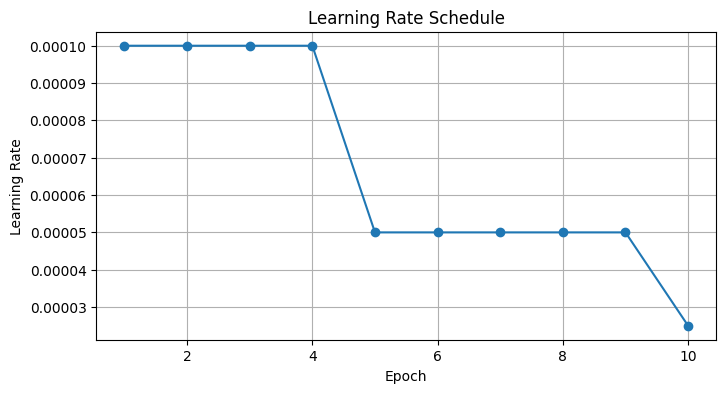

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), lrs, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

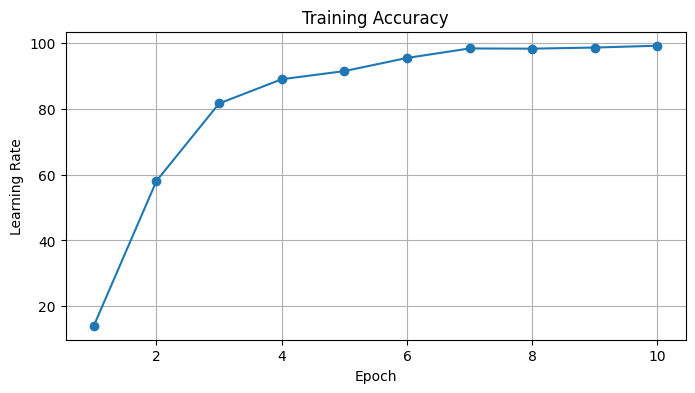

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), train_acc, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

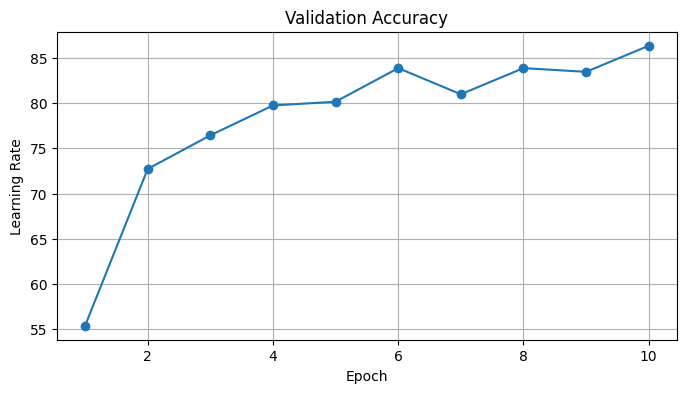

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), val_acc, marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)
vgg_finetunedmodel.eval()  # Set the model to evaluation mode
test_model(vgg_model, sushrut_test_loader, criterion, device)

Test Loss: 0.7910 | Test Accuracy: 84.75%


#### Conclusion

After data augmentation we see an increase in the testing accuracy from 84.07 to 84.75% for VGG Model

# Visualize incorrectly classified images

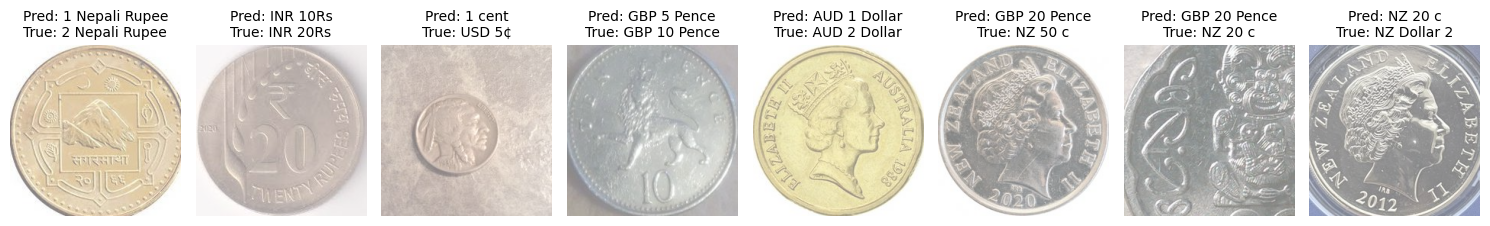

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

def show_misclassified(model, dataloader, device, label_encoder, max_images=10):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), preds[i].item(), labels[i].item()))
                if len(misclassified) >= max_images:
                    break
            if len(misclassified) >= max_images:
                break

    # Plot
    fig, axes = plt.subplots(1, len(misclassified), figsize=(15, 5))
    if len(misclassified) == 1:
        axes = [axes]

    for idx, (img, pred_idx, true_idx) in enumerate(misclassified):
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        axes[idx].imshow(img.numpy())
        axes[idx].axis('off')
        pred_label = label_encoder.inverse_transform([pred_idx])[0]
        true_label = label_encoder.inverse_transform([true_idx])[0]
        axes[idx].set_title(f'Pred: {pred_label}\nTrue: {true_label}', fontsize=10)

    plt.tight_layout()
    plt.show()

show_misclassified(alex_finetunemodel,sushrut_val_loader, device, label_encoder, max_images=8)

#### Observations and conclusions

Based on the images we see in this task, we can see that the model is able to get the country right for most of the coins. However, where the model fails is for fine grained classifications and to detect similar nuances in the coin images.

As seen in the images, countries which have same head figures(as seen in AUD, NZ, UK coins having Queen Elizabeth's image), the model finds it difficult to classify exactly which denomination it belongs to.

In addition to this, mostly the heads side of the coin is one which is wrongly classified. This is because of the variety in the heads. The tails are more often than not, rightly classified because the digits in the tails, help the model to recognize the denomination.

# Conclusion

Based on the tasks in this assignment, we can conclude that:
1. Fine tuning layers 1,2,3 out of the 8 layers for Alexnet gives best accuracy. The Step Learning Rate scheduler also reduces the learning rate in a step manner, which the graph confirms
2. Fine tuning layers 1,2,3,4,5 out of the 16 layers for VGG gives best accuracy. The Step Learning Rate scheduler also reduces the learning rate in a step manner, which the graph confirms too.
3. Data Augmentation was done on the images. The techniques involved in augmentation are: Resize, HorizontalFlip and Rotate. These are mild augmentation techniques and do not distort the original image a lot.
4. After augmentation, the fine tuned models saw an increase in the accuracy.
5. In comparison to Alexnet, VGG performed better.
6. While analysing the wrongly classified image, we see that coin images which have similar 'heads' on them across countrys(in our dataset, there are coins from different countries which have similar head figures). This causes a reduce in the accuracy.